In [1]:
import sys
sys.path.append('./pyuid3')

In [2]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from pyuid3.entropy_evaluator import *
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [4]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))

Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<AxesSubplot:xlabel='x1', ylabel='x2'>

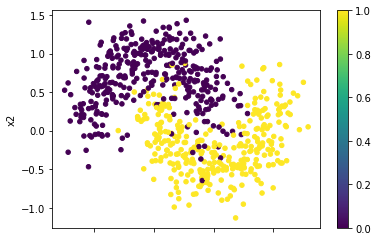

In [6]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [7]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [8]:
from sklearn.linear_model import LogisticRegression
xclf = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [9]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9363636363636364
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       153
           1       0.94      0.94      0.94       177

    accuracy                           0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330



<AxesSubplot:xlabel='x1', ylabel='x2'>

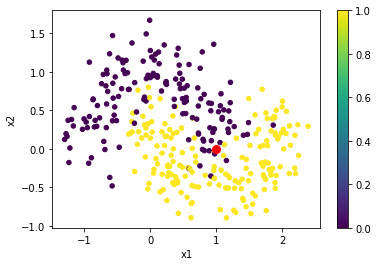

In [10]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [11]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['x1','x2']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Decision Boundaries

X does not have valid feature names, but SVC was fitted with feature names


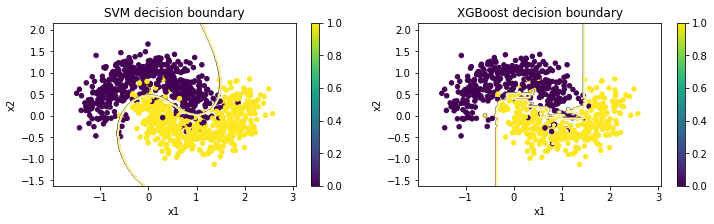

In [12]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

X does not have valid feature names, but SVC was fitted with feature names


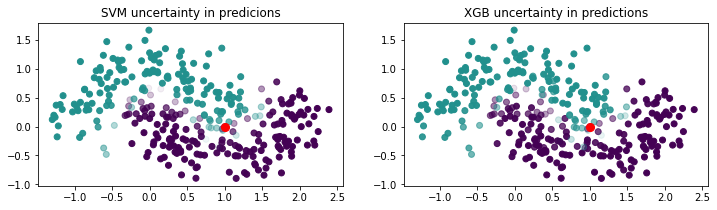

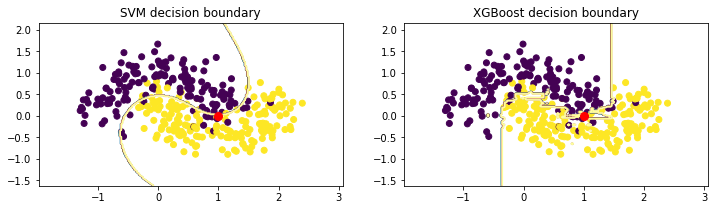

In [13]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## LUX explanations

In [14]:
from lux.lux import LUX

In [19]:
point = [0,1]
clf = xclf

lux = LUX(predict_proba = clf.predict_proba, 
          neighborhood_size=0.2,max_depth=2,  
          node_size_limit = 2, grow_confidence_threshold = 0,
          min_generate_samples=0.02 )
X_train_sample, _ = lux.create_sample_bb(X_train, y_train,np.array([point]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

In [20]:
def outliers(data,multiplier=1.5):
    # finding the 1st quartile
    q1 = np.quantile(data, 0.25)

    # finding the 3rd quartile
    q3 = np.quantile(data, 0.75)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(multiplier*iqr)
    lower_bound = q1-(multiplier*iqr)
    return (iqr, upper_bound, lower_bound)

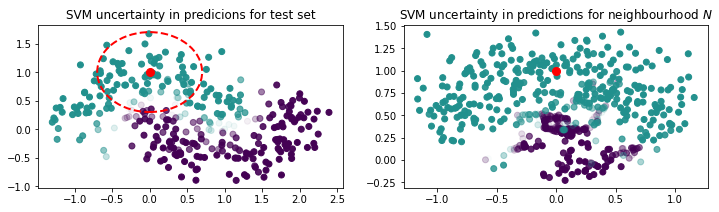

In [21]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood.png')

In [18]:
import warnings
from lux.UncertainSMOTE import UncertainSMOTE
warnings.filterwarnings('ignore')
sigma=1
for iteration in np.arange(0,1):
    sm = UncertainSMOTE(predict_proba=clf.predict_proba,sigma=sigma,sampling_strategy='all',instance_to_explain=np.array([point]).reshape(1,-1)) 
    X_train_sample, _ = sm.fit_resample(X_train_sample, np.argmax(clf.predict_proba(X_train_sample),axis=1))


## Neighbourhood plotting

In [ ]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood2.png')

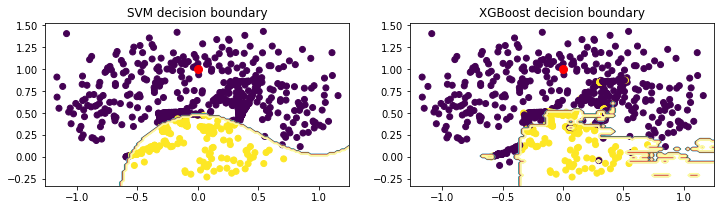

In [20]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_train_sample.values[:, 0].min() - 0.1, X_train_sample.values[:, 0].max() + 0.1
y_min, y_max = X_train_sample.values[:, 1].min() - 0.1, X_train_sample.values[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_train_sample['x1'], X_train_sample['x2'], c=svc.predict(X_train_sample), cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_train_sample['x1'], X_train_sample['x2'], c=clf.predict(X_train_sample), cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
plt.show()

In [21]:
X_train_sample.shape

(1125, 2)

## Observe split selection with SHAP

In [22]:
clfgb = xgb.XGBClassifier(eval_metric='error')
clfgb.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
explainer = shap.Explainer(clfgb, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [24]:
shap_values[0]
explainer.expected_value

0.558955305501006

In [25]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [26]:
uarff=LUX.generate_uarff(X_train_sample,clf.predict_proba(X_train_sample), X_importances=None,class_names=[0,1])
data = Data.parse_uarff_from_string(uarff)

In [27]:
datadf = data.to_dataframe()
shap_dict={}
expected_dict={}
expected_values = explainer.expected_value
for i,v in enumerate(shap_values):
    shap_dict[str(i)] = pd.DataFrame(v, columns = datadf.columns[:-1])
    expected_dict[str(i)] = expected_values[i]

data = data.set_importances(pd.concat(shap_dict,axis=1), expected_values = expected_dict)

In [28]:
data.instances[-1].get_reading_for_attribute('x2').get_most_probable().get_importances()

{'0': -0.05389999879524112, '1': 0.05389999879524112}

In [29]:
def get_maximum_label(shapdict):
            return max(shapdict, key=shapdict.get)
        
labels = [get_maximum_label(i.get_reading_for_attribute('x2').get_most_probable().get_importances()) for i in data.instances]

In [30]:
true_labels = [i.get_reading_for_attribute(data.get_class_attribute().get_name()).get_most_probable().get_name() for i in data.instances]

In [31]:
tlabels = clf.predict(datadf.iloc[:,:-1])

In [32]:
ilabels = [int(i) for i in labels]

In [33]:
(tlabels==ilabels).sum()/len(labels)

0.784

In [34]:
idx_error_x2 = datadf.iloc[np.where(tlabels!=ilabels)].index 
datadf.loc[:,'x2_shap_error'] =datadf['class']
datadf.loc[idx_error_x2,'x2_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

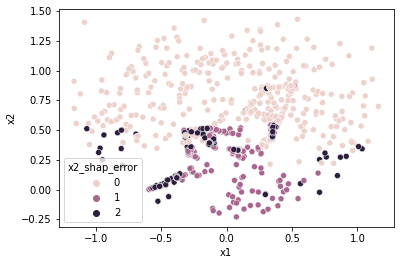

In [35]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x2_shap_error')

In [36]:
labelsx1 = [get_maximum_label(i.get_reading_for_attribute('x1').get_most_probable().get_importances()) for i in data.instances]

In [37]:
ilabelsx1 = [int(i) for i in labelsx1]
(tlabels==ilabelsx1).sum()/len(labels)

0.8106666666666666

In [38]:
idx_error_x1 = datadf.iloc[np.where(tlabels!=ilabelsx1)].index 
datadf.loc[:,'x1_shap_error'] =datadf['class']
datadf.loc[:,'x1_shap'] =ilabelsx1
datadf.loc[idx_error_x1,'x1_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

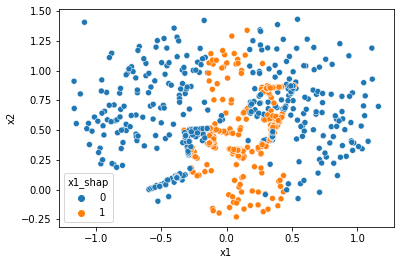

In [39]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap')

<AxesSubplot:xlabel='x1', ylabel='x2'>

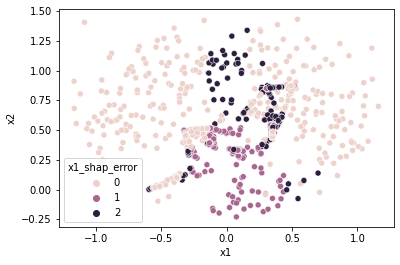

In [40]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap_error')

<AxesSubplot:xlabel='x1', ylabel='x2'>

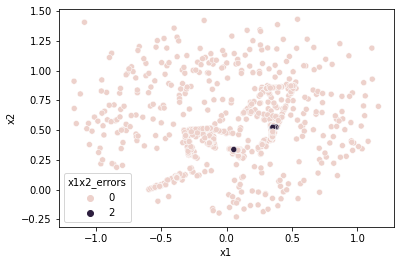

In [41]:
datadf['x1x2_errors']=0
datadf.loc[(datadf['x1_shap_error']==2) & (datadf['x2_shap_error']==2),'x1x2_errors'] =2
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1x2_errors')

In [ ]:
import random
from sklearn.ensemble import GradientBoostingClassifier
i=0
with open('shap_ig_dt_oblique_os.csv', 'w') as fi: 
    for f in range(4,10):
        for _ in range(1,10):
            X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f, random_state=3,
                                                           n_informative=int(f/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(f/3),
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#
            blackbox = GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))


            # lux = LUX(classifier=blackbox,predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
            # X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
            #                                      exclude_neighbourhood=False, use_parity=True, 
            #                                      inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
            #                                      oversampling=True,
            #                                      representative='centroid')
            data = Data.parse_dataframe(train)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            t,log = uid3.fit(data,classifier=blackbox, depth=0,entropyEvaluator = UncertainEntropyEvaluator(),
                             discount_importance=False, oblique=True,
                             prune=True,n_jobs=-1,logo=str(i))
            print(f"{log}", file=fi, end='')
            #print(f"{i},{log}")
            i+=1
        

Exact explainer: 671it [00:15, 22.90it/s]                                                                                                                                  
Exact explainer: 671it [00:10,  1.75it/s]                                                                                                                                  
Exact explainer: 671it [00:10,  1.18it/s]                                                                                                                                  
Exact explainer: 671it [00:10,  2.52s/it]                                                                                                                                  
Exact explainer: 671it [00:10,  1.02s/it]                                                                                                                                  
Exact explainer: 671it [00:10,  1.08it/s]                                                                                                   

In [ ]:
print('asd')

In [ ]:
v=['1','0','1']
k=(np.array(v)=='1')

In [ ]:
k

In [ ]:
print('asdasd')